In [ ]:
from stanley_appex.estimation import *
from stanley_appex.plotting import *
from stanley_appex.utils import *
from stanley_appex.generate_data import *
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

In [24]:

path = "/Users/stanleynicholson/code/Bjorn/Optimal Transport/OTProject/trajectory_inference/src/data/larger_noise/"
files = ["data_imaginary_ds10.h5",
"data_imaginary_ds50.h5",
"data_negative_ds10.h5",
"data_negative_ds50.h5",
"data_positive_ds10.h5",
"data_positive_ds50.h5"]

In [ ]:
def run_appex(hfile, A_guess = 0.01*np.eye(2), H_guess = np.eye(2), maxiters=30, return_errors=False):

    # xs_data: (N, N_traj, d)
    # ts_data: (N,)
    downsample_rate = hfile['xs_data'].attrs['downsample_rate']
    N_traj = hfile['xs_data'].attrs['N_traj']

    ts_data = hfile['ts_data'][:]
    xs_data = hfile['xs_data'][:].transpose(1, 0, 2)

    ridge_lambda = 0.0
    print(xs_data.shape, ts_data.shape)
    As, Hs, Pis = appex_rectangle(xs_data, ts_data, A_guess, H_guess, N_sample=N_traj*10, ridge_lambda=ridge_lambda, tol=1e-5, maxiters=maxiters, print_out=10, save_coupling=True, reverse=False)

    A_est = As[-1]
    H_est = Hs[-1]
    Pi_est = Pis[-1]
    print("A_est:\n", A_est)
    print("H_est:\n", H_est)
    
    A_true = hfile['xs_data'].attrs['A']
    G_true = hfile['xs_data'].attrs['G']
    H_true = G_true @ G_true.T
    
    if return_errors:
        A_errors = [np.linalg.norm(A - A_true, ord="fro") for A in As]
        H_errors = [np.linalg.norm(H - H_true, ord="fro") for H in Hs]
    
        return A_est, H_est, A_errors, H_errors
    else:
        return A_est, H_est


In [30]:
A_appexs = []
A_grits = []
A_trues = []
for file in files:
    try:
        hfile = h5py.File(os.path.join(path, file), 'r')
        print("Running file: ", file)
    
        A_trues.append(hfile['xs_data'].attrs['A'])
        A_est, H_est, A_errors, H_errors = run_appex(hfile, maxiters=30)
        A_appexs.append(A_est)
        
        
        hfile.close()
    except Exception as e:
        print("Error processing file: ", file)
        print(e)
        A_appexs.append(np.nan)
        A_grits.append(np.nan)
        A_trues.append(np.nan)

Running file:  data_imaginary_ds10.h5
(150, 50, 2) (150,)
iteration 0, running tolerance 1.9900251254695254
iteration 10, running tolerance 0.00886823083011381
iteration 20, running tolerance 0.015331868447471156
A_est:
 [[-0.04730275 -0.48312065]
 [ 0.47765555 -0.06026274]]
H_est:
 [[1.18586243 0.0098174 ]
 [0.0098174  1.15958205]]
Running file:  data_imaginary_ds50.h5
(30, 50, 2) (30,)
iteration 0, running tolerance 1.9900251254695254
iteration 10, running tolerance 0.012489107936538351
iteration 20, running tolerance 0.017532487335920728
A_est:
 [[-0.20463848 -0.30958746]
 [ 0.23903938 -0.23503389]]
H_est:
 [[0.95472919 0.03495372]
 [0.03495372 0.80022024]]
Running file:  data_negative_ds10.h5
(150, 50, 2) (150,)
iteration 0, running tolerance 1.9900251254695254
iteration 10, running tolerance 0.022531089097026124
iteration 20, running tolerance 0.07599199052237739
A_est:
 [[-1.12943516  0.07851016]
 [ 0.0878803  -1.13624238]]
H_est:
 [[0.74412203 0.14626664]
 [0.14626664 0.754102  

In [32]:
for i in range(len(A_appexs)):
    if isinstance(A_appexs[i], np.ndarray):
        print("A_appexs:\n", np.round(A_appexs[i], 2))
        # print("A_grits:\n", np.round(A_grits[i], 2))
        print("A_trues:\n", np.round(A_trues[i], 2))
        print("---------------------------")


A_appexs:
 [[-0.05 -0.48]
 [ 0.48 -0.06]]
A_trues:
 [[ 0.  -0.5]
 [ 0.5  0. ]]
---------------------------
A_appexs:
 [[-0.2  -0.31]
 [ 0.24 -0.24]]
A_trues:
 [[ 0.  -0.5]
 [ 0.5  0. ]]
---------------------------
A_appexs:
 [[-1.13  0.08]
 [ 0.09 -1.14]]
A_trues:
 [[-0.5  0.1]
 [ 0.1 -0.5]]
---------------------------
A_appexs:
 [[-0.45  0.05]
 [-0.01 -0.4 ]]
A_trues:
 [[-0.5  0.1]
 [ 0.1 -0.5]]
---------------------------


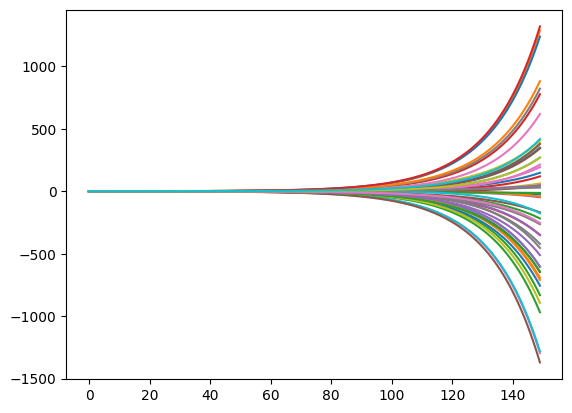

In [15]:
plt.plot(h5py.File(os.path.join(path, files[-2]), 'r')["xs_data"][:][:, :, 0].T);